In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Fetch the data from the csv files inside the data folder named final_datasets
X_train = pd.read_csv('final_datasets/X_train.csv')
X_test = pd.read_csv('final_datasets/X_test.csv')
y_train = pd.read_csv('final_datasets/y_train.csv')
y_test = pd.read_csv('final_datasets/y_test.csv')

### __1. PCA__
We have a training set with $1000$ SN data points (SN events), each consisting of $30$ numerical features.
Similarly, we have $250$ points for the test set.\
Now we would like to __reduce the dimensionality__ of this dataset using Principal Component Analysis (PCA).

#### __1.1 Identify the Principal Components__
We first need to identify the optimal number of components to be retained during PCA. 
We can do this by locating the __elbow point__ in the eigenvalues of the covariance matrix: at the elbow point, the eigenvalues start to plateau, suggesting diminishing returns in terms of variance explained.\
We can achieve the same goal by building the so-called **scree plot**, which lets us visualize the amount of variance explained by each principal component. We get the explained variance ratios from PCA using the `scikit-learn.decomposition` - `PCA` module, then plotting them just to get the same results $^1$ in terms of variance ratio.

In [2]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA()

Text(7, 0.0125, 'Elbow Point')

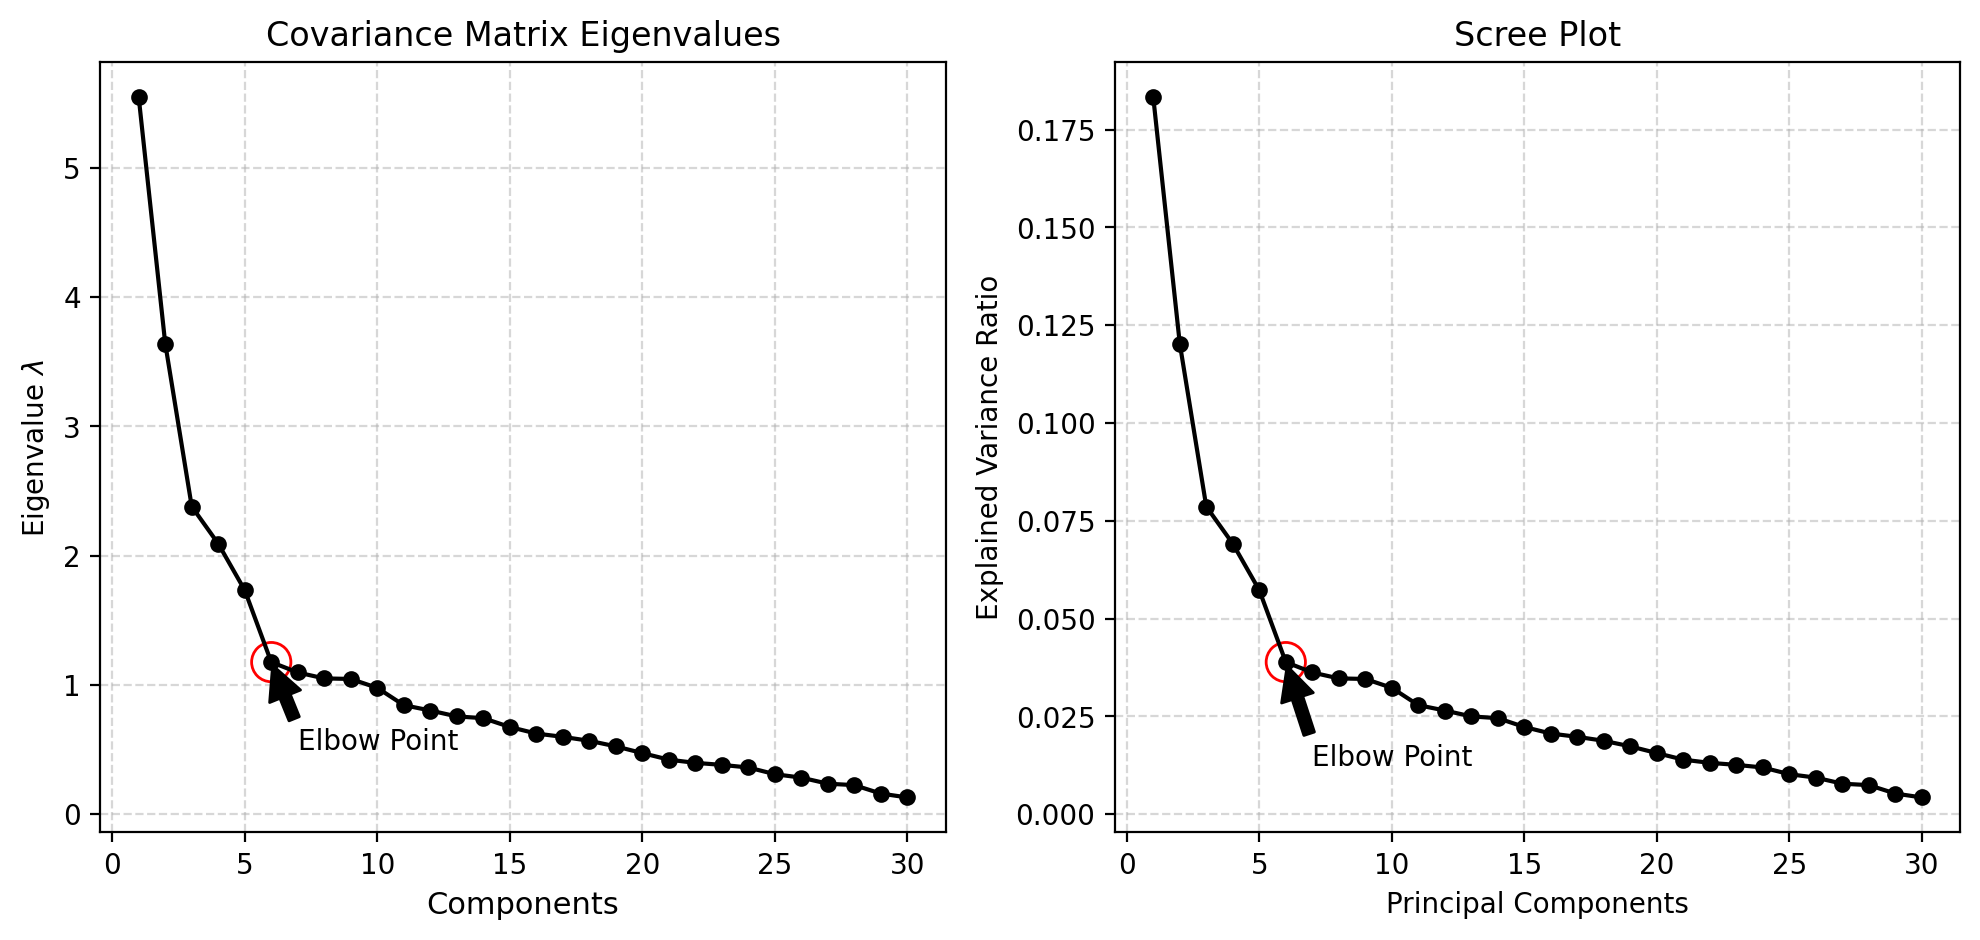

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Get the covariance matrix of the training data
cov_matrix = X_train.cov().to_numpy()

# Calculate the eigenvalues of the covariance matrix
eigenvalues = np.linalg.eigvals(cov_matrix)

# Plot the eigenvalues in descending order
ax[0].plot(np.array(range(1, len(eigenvalues)+1)), np.sort(eigenvalues)[::-1], 'k-o', markersize=5)
ax[0].set_xlabel('Components', fontsize=11)
ax[0].set_ylabel('Eigenvalue $\lambda$')
ax[0].grid(True, alpha=0.5, linestyle='--')
ax[0].set_title('Covariance Matrix Eigenvalues', fontsize=12)

# Circle the elbow point
ax[0].scatter(6, eigenvalues[5], s=200, facecolors='none', edgecolors='r')
ax[0].annotate('Elbow Point', xy=(6, eigenvalues[5]), xytext=(7, 0.5), arrowprops=dict(facecolor='black', shrink=0.05))

# Plot the explained variance ratio
ax[1].plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'k-o', markersize=5)
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Explained Variance Ratio')
ax[1].grid(True, alpha=0.5, linestyle='--')
ax[1].set_title('Scree Plot')

ax[1].scatter(6, pca.explained_variance_ratio_[5], s=200, facecolors='none', edgecolors='r')
ax[1].annotate('Elbow Point', xy=(6, pca.explained_variance_ratio_[5]), 
               xytext=(7, 0.0125), arrowprops=dict(facecolor='black', shrink=0.05))

<font size=2>

$[1]$: as you can see, the two plots may look a bit different, but this is due to the different scale used on the $y$-axis. Also notice that, on the plots, we begin to count the number of PCs from $1$, while all the array indexing starts with $0$.
</font>

#### __1.2 Cumulative Variance__
We now want to illustrate the cumulative amount of variance explained by a certain number of principal components. In our situation, we can assume that the optimal number of PCs is $d=6$.\
The Cumulative Variance is useful for determining how much of the total variance in the dataset is captured as more principal components are included.

Similarly, we can also __fix__ the cumulative explained variance value and derive the number of principal components needed to achieve this value.

Cumulative Sum of the first 6 components: 0.548
Number of components to retain 80% of the total variance: 15


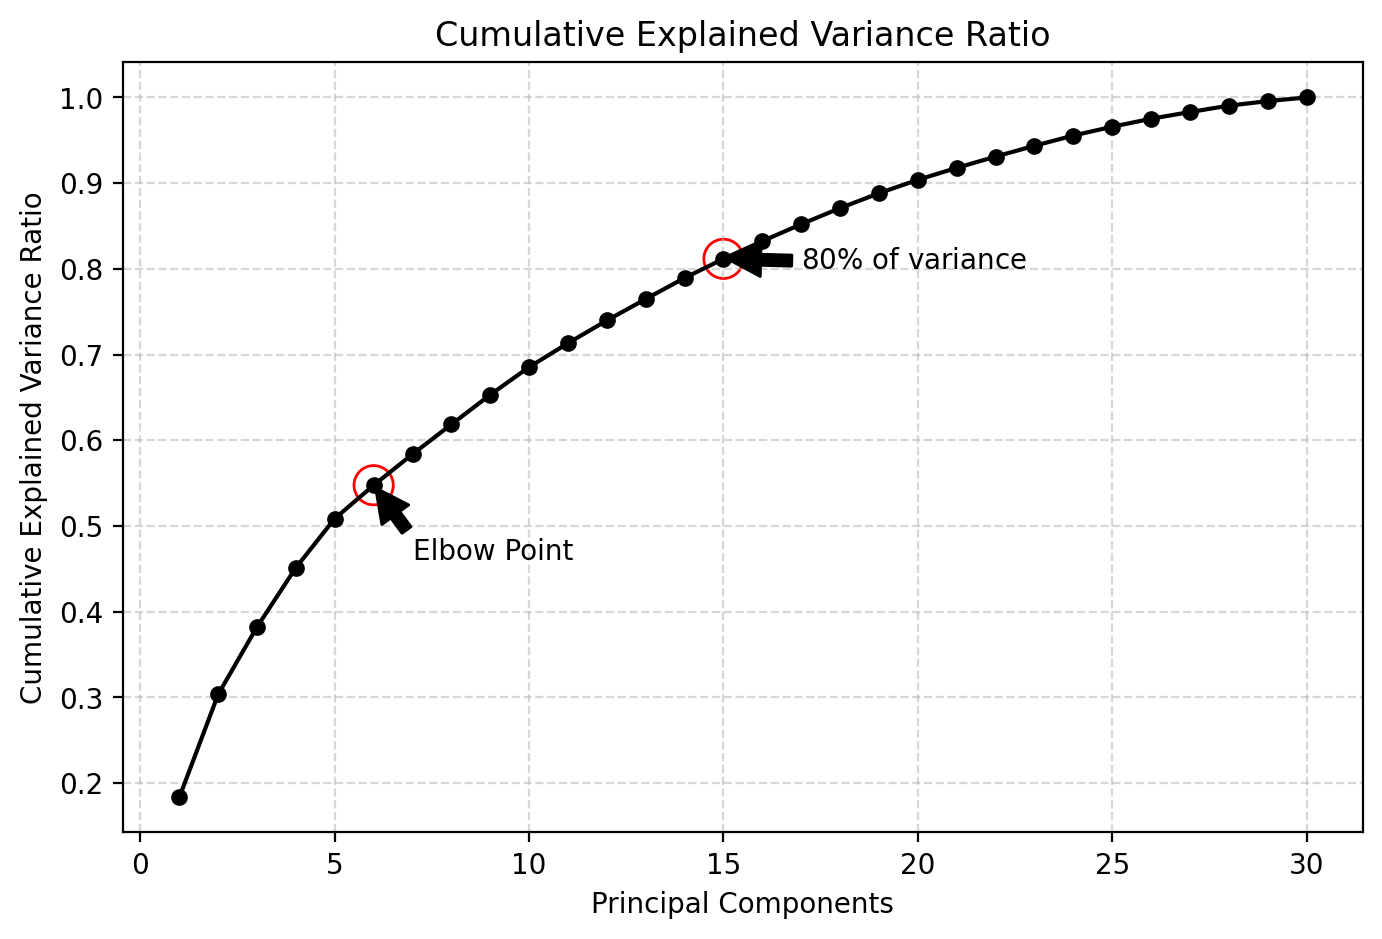

In [4]:
# Cumulative sum of the EVR
cumsum = np.cumsum(pca.explained_variance_ratio_[:6])
print(f'Cumulative Sum of the first 6 components: {cumsum[-1]:.3f}')

# Fix the total variance to 90% and find the number of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
# 80% of the total variance is contained in the first d dimensions
print(f'Number of components to retain 80% of the total variance: {d}')

# Plot the cumulative sum of the EVR
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumsum) + 1), cumsum, 'k-o', markersize=5)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True, alpha=0.5, linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.scatter(6, cumsum[5], s=200, facecolors='none', edgecolors='r')
plt.annotate('Elbow Point', xy=(6, cumsum[5]), xytext=(7, 0.46), arrowprops=dict(facecolor='black', shrink=0.05))
plt.scatter(d, cumsum[d-1], s=200, facecolors='none', edgecolors='r')
plt.annotate('$80\%$ of variance', xy=(d, cumsum[d-1]), xytext=(d+2, 0.8), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

We can now see how the transition to the plateau regime is no longer so evident, although a slight change in slope can be observed in correspondence with the elbow point. This leads us to think that, in order to significantly reduce the number of dimensions, we would also have to give up a good chunk of explained variance.\
However, the aim of the project is mainly instructional and we have no intention of finding the perfect classifier. This is why we do not require a typically very high level of variance $(90\%-95\%)$, but instead choose $d=6$, preserving about $55\%$ of variance. We will eventually restore all the parameters for the classifier at the end of the project.

#### __Features and PCs Relation__
To find the relations between the Principal Components (PCs) and the original features, we examine the __loading matrix__. The loading matrix, denoted as $\mathcal{L}$, provides the coefficients that express the linear combination of the original features to obtain each principal component. The relation is the following (in tensor notation):

$$ PC_i = \mathcal{L}^j_i X_j $$

where:
- $ PC_i $ is the $i$-th Principal Component,
- $ \mathcal{L}^j_i $ is the loading (coefficient) of the $j$-th original feature in the $i$-th Principal Component,
- $ X_j $ is the $j$-th original feature.

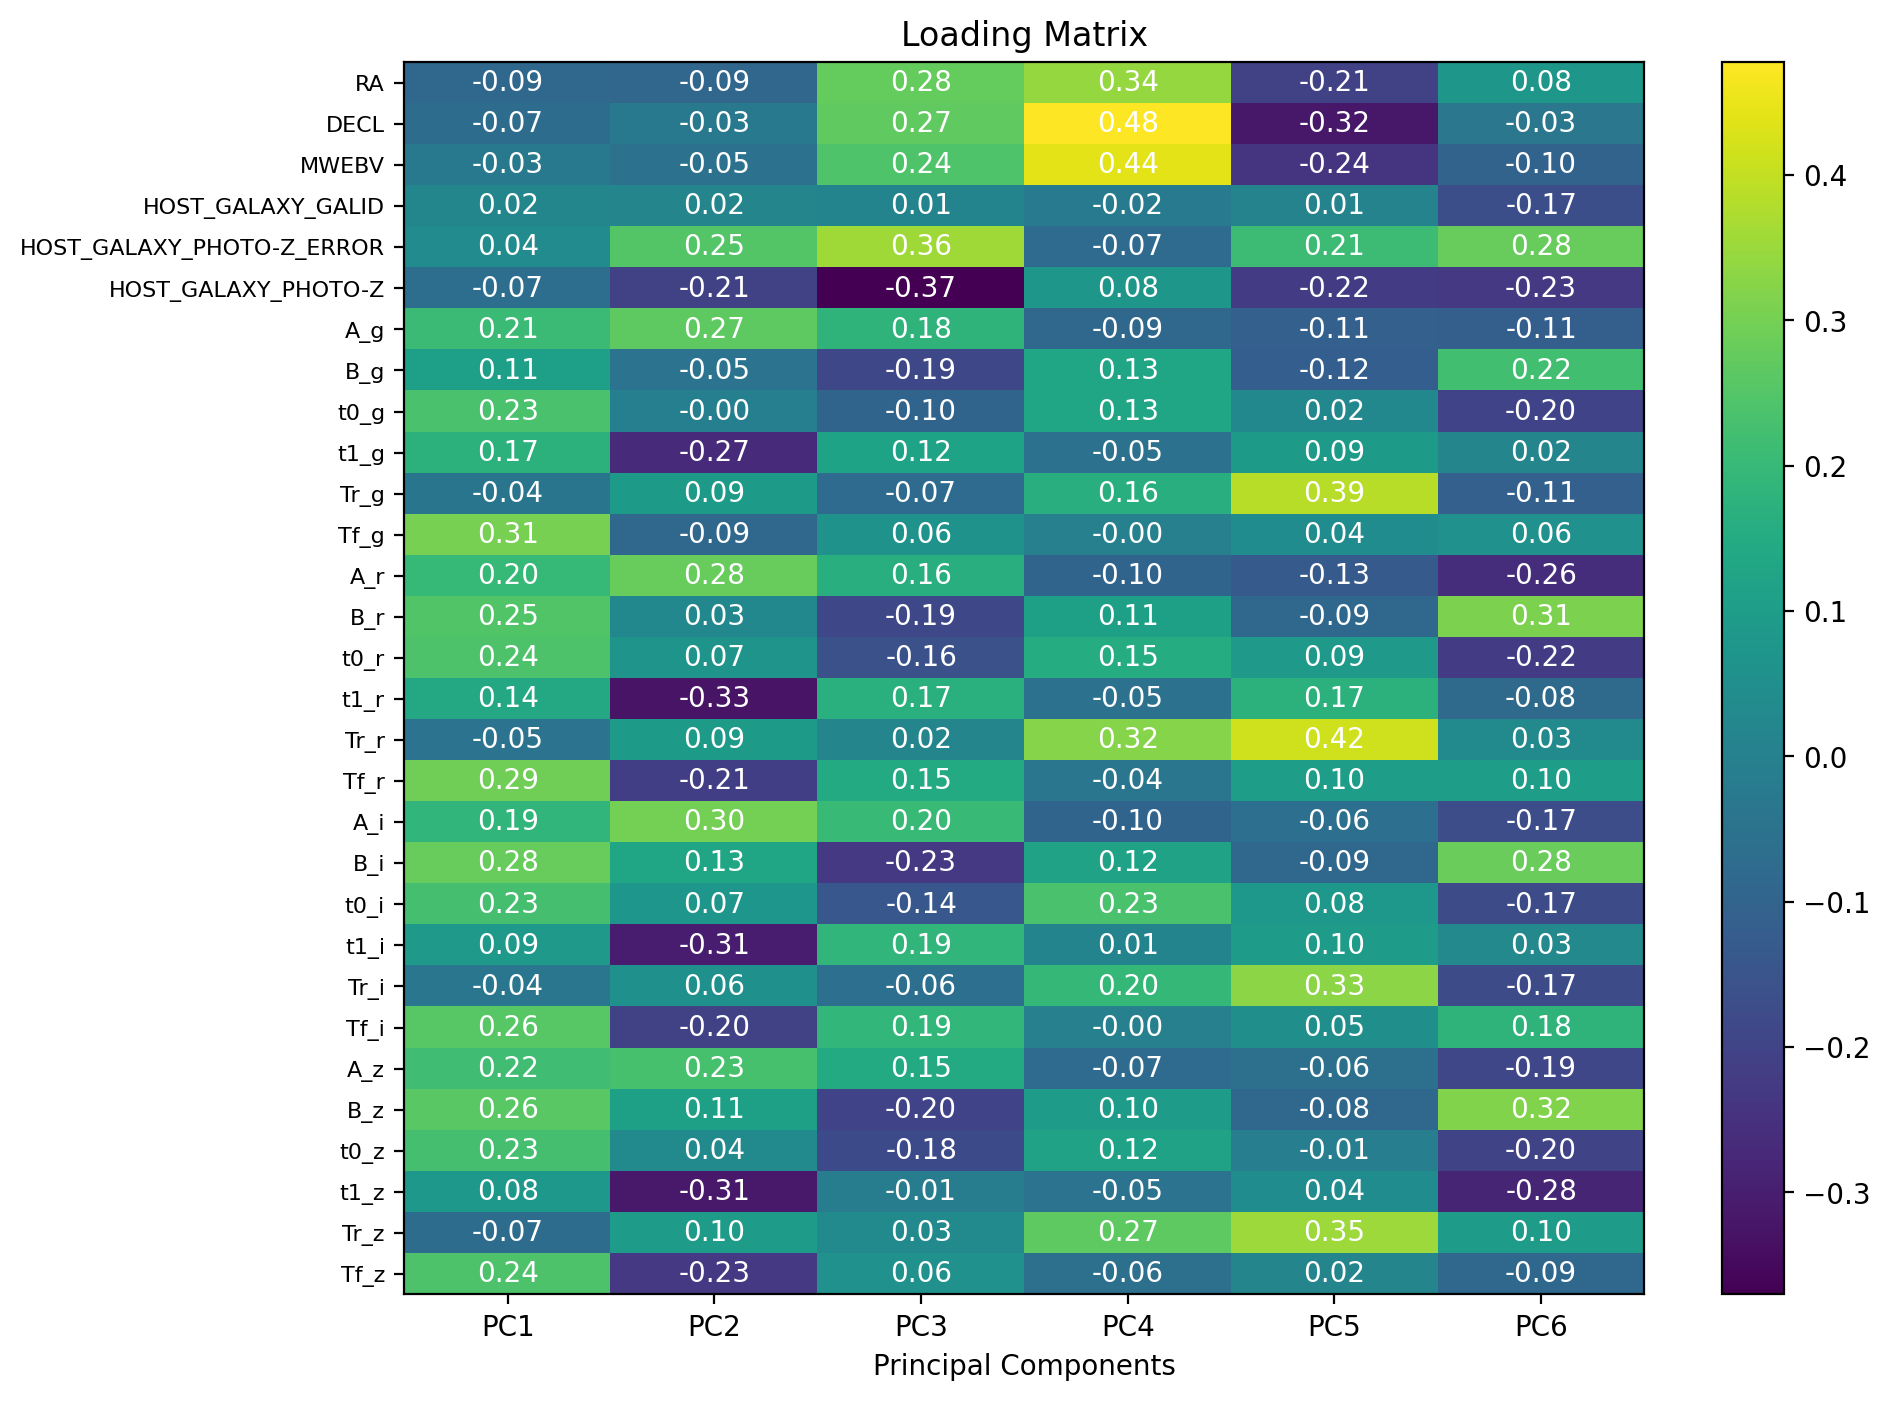

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
principal_components = pca.fit_transform(X_train)
# Create a DataFrame for principal components
pc_X_train = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(6)])

# Create a DataFrame for loading matrix (coefficients of original variables in principal components)
loading_matrix = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(6)], 
                              index=X_train.columns)

# Plot the loading matrix using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(loading_matrix, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(loading_matrix.columns)), loading_matrix.columns)
plt.xlabel('Principal Components')
plt.yticks(range(len(loading_matrix.index)), loading_matrix.index, fontsize=8)
plt.title('Loading Matrix')
# Display the loading matrix values inside the heatmap cells
for i in range(len(loading_matrix.index)):
    for j in range(len(loading_matrix.columns)):
        plt.text(j, i, f'{loading_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w')
plt.show()

Unfortunately, it is evident that the principal components are not significantly associated with any of the original features.\ The only signs of positive correlation are found at: *PC3*, for which there is a correlation of $0.36$ with the redshift of the host galaxy, and *PC4*, which has a correlation of $0.44$ with `MWEBV` and $0.48$ with the declination feature. Looking at the first two PCs, however, it is evident that they receive significant - but reduced - contributions from many features at the same time.\
However, this should not discourage us: as explained in the `data.ipynb` notebook, feature extraction has *no real physical meaning*, so we could not a priori expect any particular relationship between the principal components and the light curve parameters: it is more reasonable to expect the PCs to be associated with some combination of these parameters, which is exactly what the loading matrix is telling us.

We therefore continue to work on the projected space along the PCs, in search of a more evident subdivision of the SN types.

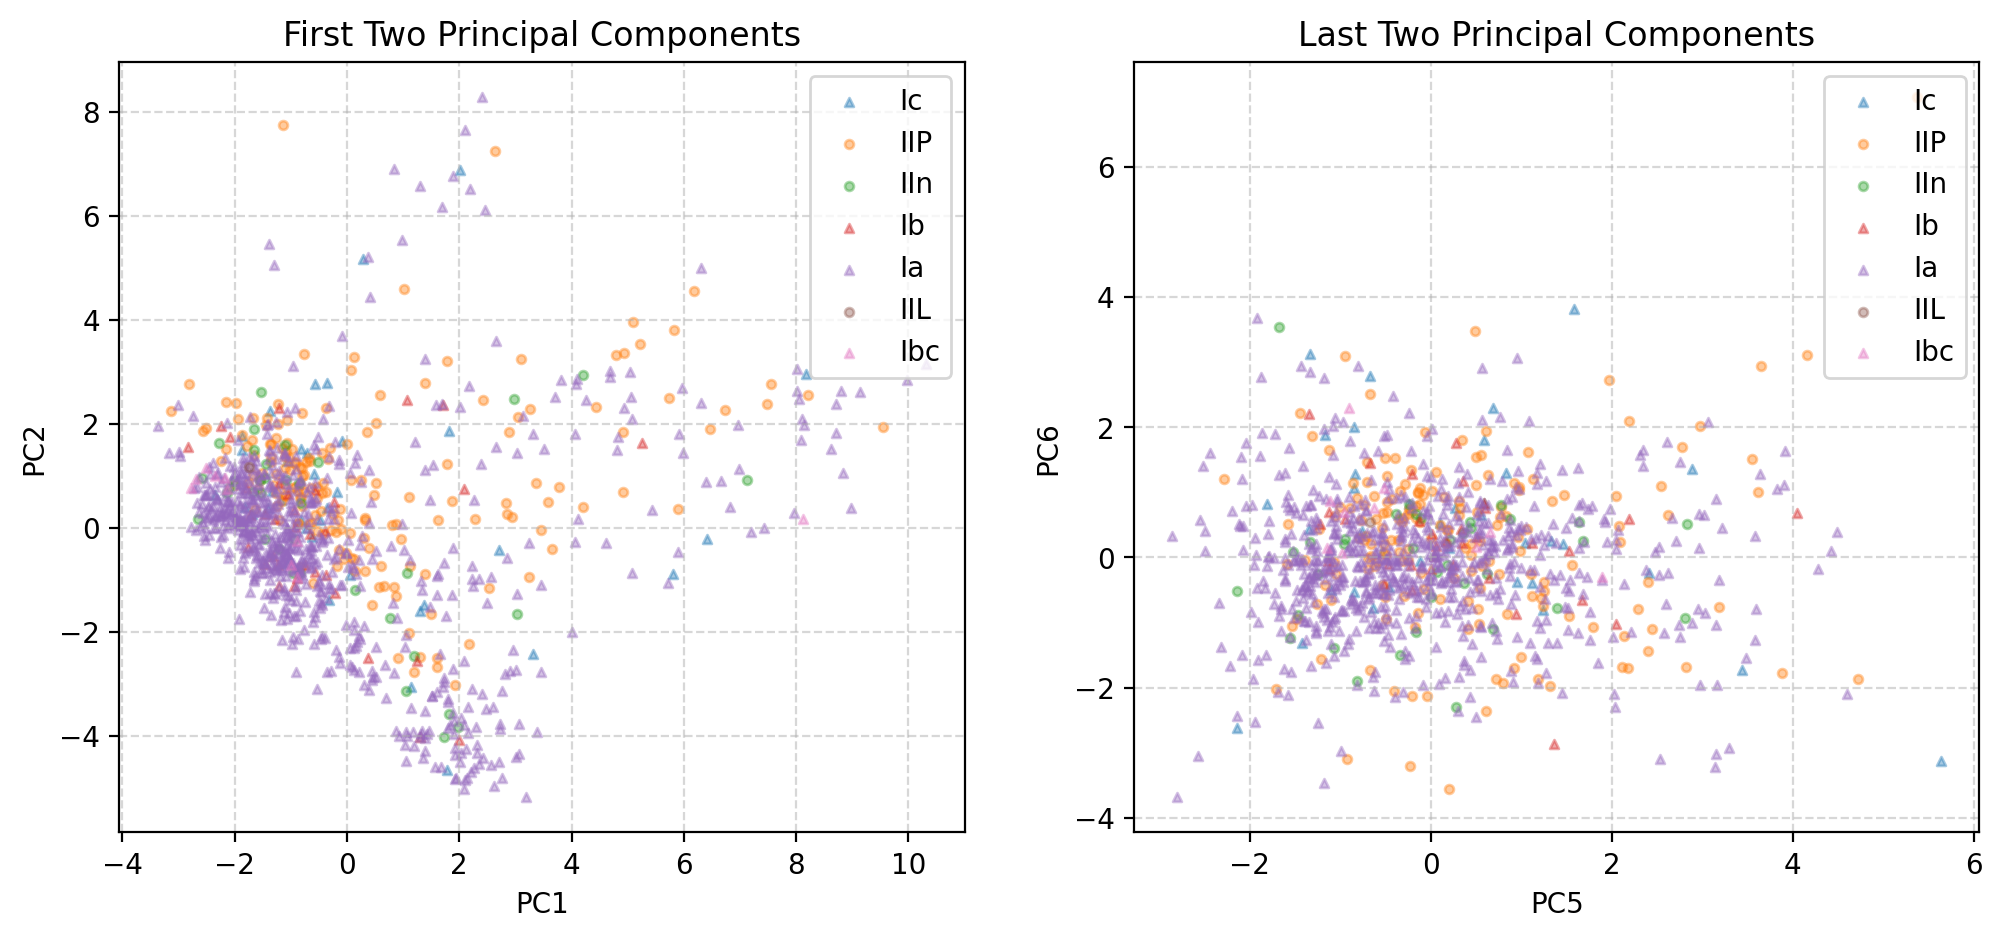

In [9]:
# Plot the first two principal components, colored by the target variable found in y_train.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Define the targets as a set
targets = set(y_train['SNTYPE'])
# Iterate over the targets and plot each one
for target in targets:
    indices = y_train[y_train['SNTYPE'] == target].index
    if target.count('I') == 1:
        ax[0].scatter(pc_X_train.loc[indices, 'PC1'], pc_X_train.loc[indices, 'PC2'], label=target, alpha=0.4, s=10, marker='^')
    else:
        ax[0].scatter(pc_X_train.loc[indices, 'PC1'], pc_X_train.loc[indices, 'PC2'], label=target, alpha=0.4, s=10)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('First Two Principal Components')
ax[0].grid(True, alpha=0.5, linestyle='--')
ax[0].legend(loc='upper right')

# Do the same thing for PC5 and PC6
for target in targets:
    indices = y_train[y_train['SNTYPE'] == target].index
    if target.count('I') == 1:
        ax[1].scatter(pc_X_train.loc[indices, 'PC5'], pc_X_train.loc[indices, 'PC6'], label=target, alpha=0.4, s=10, marker='^')
    else:
        ax[1].scatter(pc_X_train.loc[indices, 'PC5'], pc_X_train.loc[indices, 'PC6'], label=target, alpha=0.4, s=10)

ax[1].set_xlabel('PC5')
ax[1].set_ylabel('PC6')
ax[1].set_title('Last Two Principal Components')
ax[1].grid(True, alpha=0.5, linestyle='--')
ax[1].legend()

On the projection along *PC1* and *PC2*, there is some localisation of Type I SNs, especially Ia, in the central region and in the low *PC2*, medium *PC1* region, while Type II SNs are more localised in the medium *PC2*, low *PC1* region. However, it should be emphasised that the distribution does not present clear subdivisions.\
On the other hand, if we plot the same graph for the 2 components with less variance *PC5* and *PC6*, we notice a much more chaotic and, apparently, random distribution.

#### __Custom PCA__
For instructional purposes, I wrote a short class that performs the operations of principal component analysis on any dataframe: in this way, it is possible to trace the operations performed by `scikit-learn`.

The `fit` method calculates the eigenvectors and eigenvalues of the covariance matrix, sorting them in descending order,
as well as the *explained variance ratio*. The EVR was computed using the following relation:
$$EV_i = \frac{\sigma^2_i}{ \sum_{i}^{m} \sigma^2_i }$$
where $\sigma^2_i$ is the variance associated to the $i$-th PC and $m$ is the total number of PCs.\
It is possible to prove that $\sigma^2_i \equiv \lambda_i$, therefore the relation becomes:
$$EV_i = \frac{\lambda_i}{ \sum^{m}_j \lambda_j }$$

The `transform` method projects the data onto the principal components: $X_{proj} = X \cdot W_d$, where $W_d$ is the projection matrix, containing the first $d$ eigenvectors on the columns.

In [7]:
from python_scripts.unsupervised import *
    
# Create an instance of the CustomPCA class
custom_pca = CustomPCA(n_components=6)
# Fit the training data
custom_pca.fit(X_train)
# Transform the training data
custom_pc_X_train = custom_pca.transform(X_train)

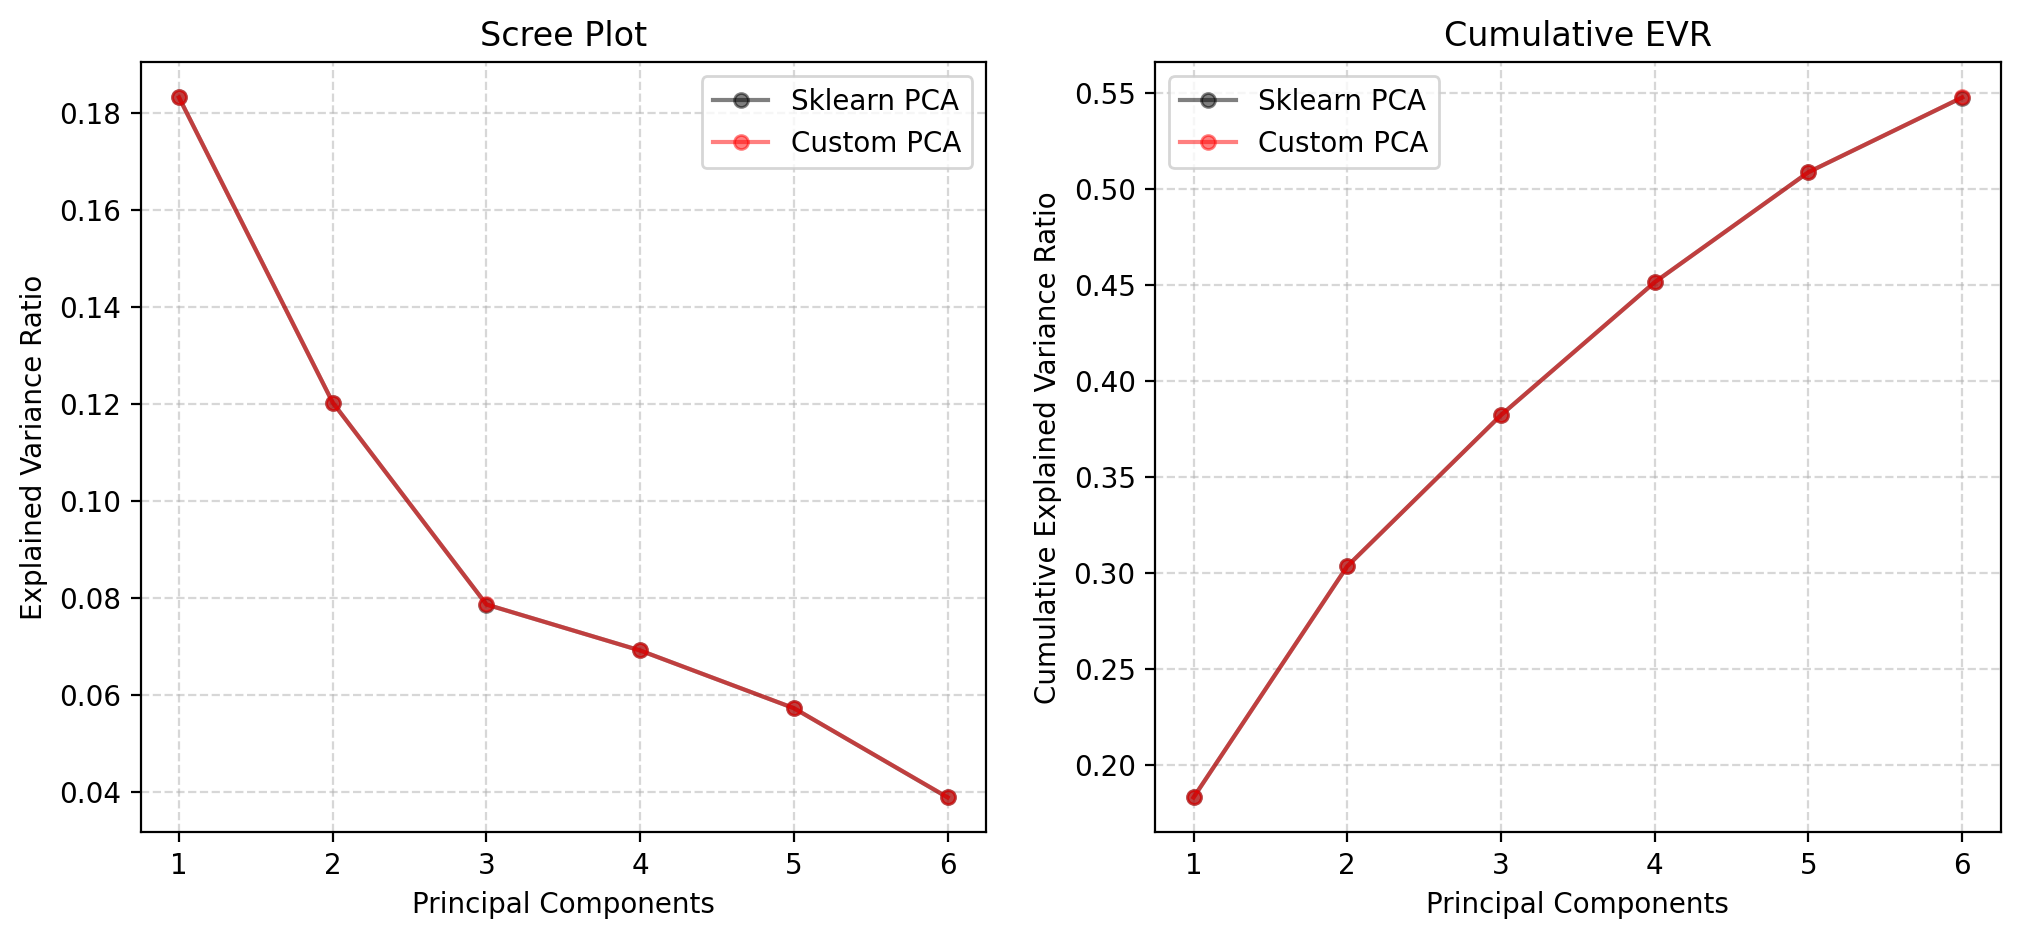

In [8]:
# Check if the results are the same as the sklearn PCA
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Use scikit-learn PCA to display the first 6 eigenvalues: plot the explained variance ratio
ax[0].plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'k-o', markersize=5,
           label='Sklearn PCA', alpha=0.5)

# Use the custom PCA to display the first 6 eigenvalues: plot the explained variance ratio
ax[0].plot(range(1, len(custom_pca.explained_variance_ratio)+1), custom_pca.explained_variance_ratio, 'r-o', markersize=5,
           label='Custom PCA', alpha=0.5)
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].grid(True, alpha=0.5, linestyle='--')
ax[0].set_title('Scree Plot')
ax[0].legend()

# Use scikit-learn PCA to display the cumulative sum of the EVR
cumsum = np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(range(1, len(cumsum) + 1), cumsum, 'k-o', markersize=5, label='Sklearn PCA', alpha=0.5)

# Use the custom PCA to display the cumulative sum of the EVR
ax[1].plot(range(1, len(np.cumsum(custom_pca.explained_variance_ratio))+1), np.cumsum(custom_pca.explained_variance_ratio), 
           'r-o', markersize=5, label='Custom PCA', alpha=0.5)
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Cumulative Explained Variance Ratio')
ax[1].grid(True, alpha=0.5, linestyle='--')
ax[1].set_title('Cumulative EVR')
ax[1].legend()


We get the same results as the sklearn PCA.